In [7]:
%matplotlib inline
# Switch to ''%matplotlib ipympl' for interactive plots
import warnings
import imp
import pickle
import lmfit
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

# Styling
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [8]:
# Initialise wrapper and test datasets
wrapper_fpath = (r"..\mobius.py")
wr = imp.load_source('mobius', wrapper_fpath)
wr.initialize('..\..\Applications\SimplyC\SimplyC.dll')

# Calibration functions
calib_fpath = (r"..\mobius_calib_uncert_lmfit.py")
cu = imp.load_source('mobius_calib_uncert_lmfit', calib_fpath)

In [9]:
# Load dataset
dataset = wr.DataSet.setup_from_parameter_and_input_files('../../Applications/SimplyC/Storgama/params_Storgama_noGW.dat', 
                                                          '../../Applications/SimplyC/Storgama/inputs_Storgama.dat')

In [10]:
# List of simulated and observed variables to investigate for Morsa
 comparisons = [('Reach flow (daily mean, cumecs)', ['Storgama'], 'Observed flow', []),
                ('Reach DOC concentration (volume weighted daily mean)', ['Storgama'], 'Observed DOC', []),          
               ]

In [11]:
# Get parameter values defined in 'dataset'
param_df = cu.get_double_parameters_as_dataframe(dataset)
param_df

,name,unit,index,min_value,initial_value,max_value
0,Latitude,°,(),-90.00000,59.000,9.000000e+01
1,Initial snow depth as water equivalent,mm,(),0.00000,250.000,5.000000e+04
2,Degree-day factor for snowmelt,mm/°C/day,(),0.00000,2.000,5.000000e+00
3,Proportion of precipitation that contributes t...,dimensionless,(),0.00000,0.000,1.000000e+00
4,PET multiplication factor,dimensionless,(),0.00000,0.300,2.000000e+00
5,Soil field capacity,mm,(),0.00000,50.000,1.000000e+03
6,Baseflow index,dimensionless,(),0.00000,0.700,1.000000e+00
7,Groundwater time constant,days,(),0.50000,65.000,4.000000e+02
8,Minimum groundwater flow,mm/day,(),0.00000,0.000,1.000000e+01
9,Manning's coefficient,s/(m^1/3),(),0.01200,0.040,1.000000e-01



Goodness of fit for Reach flow (daily mean, cumecs) [Storgama] vs Observed flow []:
Mean error (bias): -0.003462
Mean absolute error: 0.013121
Root mean square error: 0.027181
Nash-Sutcliffe coefficient: 0.319551
Number of observations: 10226


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [Storgama] vs Observed DOC []:
Mean error (bias): -1.576913
Mean absolute error: 1.637342
Root mean square error: 1.915927
Nash-Sutcliffe coefficient: -0.829073
Number of observations: 1410



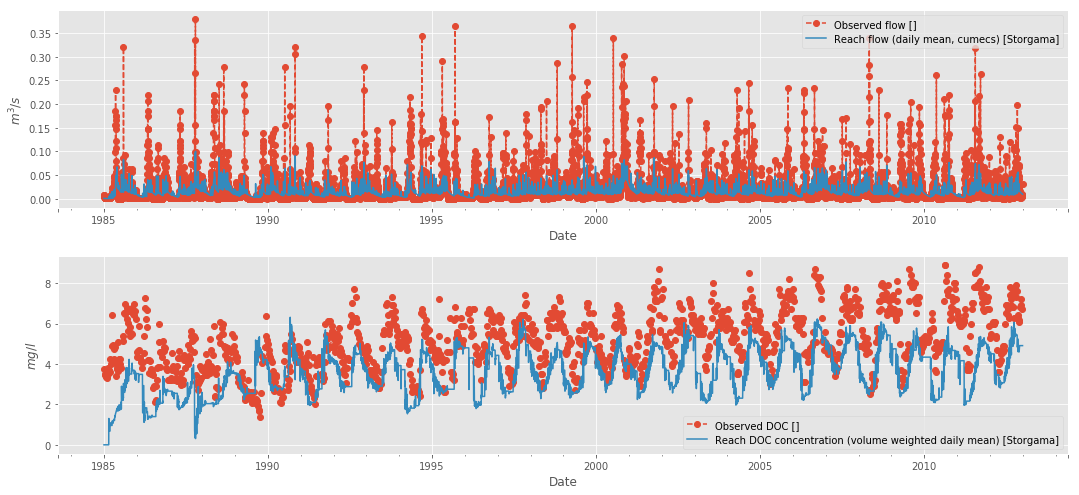

In [12]:
# Plot results from manual calibration
dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)

In [14]:
# Get params to be calibrated
calib_df = param_df.loc[[2,3,4,5,6,7,9,14,16,18,19,20,21]].reset_index(drop=True)
calib_df

,name,unit,index,min_value,initial_value,max_value
0,Degree-day factor for snowmelt,mm/°C/day,(),0.000,2.000,5.000
1,Proportion of precipitation that contributes t...,dimensionless,(),0.000,0.000,1.000
2,PET multiplication factor,dimensionless,(),0.000,0.300,2.000
3,Soil field capacity,mm,(),0.000,50.000,1000.000
4,Baseflow index,dimensionless,(),0.000,0.700,1.000
5,Groundwater time constant,days,(),0.500,65.000,400.000
6,Manning's coefficient,s/(m^1/3),(),0.012,0.040,0.100
7,Soil water time constant,days,"(All,)",0.010,0.500,40.000
8,Snow depth / soil temperature factor,/cm,(),-3.000,-0.001,-0.001
9,"Soil thermal conductivity (W/m/°C, range 0.4-0...",1E-6 m2/s,"(All,)",0.010,0.010,0.800


In [15]:
# Add 'short_name' column for calibrating parameters
calib_df['short_name'] = ['DDFmelt',
                           'fquick',
                           'alphaPET',
                           'FC',
                           'bfi',
                           'T_g',
                           'C_m',
                           'T_s',
                           'Tsoil_snowdepth',
                           'Soil_K',
                           'DOCsoilT',
                           'DOCsoilSO4',
                           'DOC_bsl',
                           ]

In [18]:
# Convert to LMFit parameter object
params = cu.parameter_df_to_lmfit(calib_df)

# Optionally refine prior ranges
params['DDFmelt'].min = 0.05
params['DDFmelt'].max = 4

params['fquick'].min = 0.0
params['fquick'].max = 0.2

params['T_s'].max = 15

params['T_g'].max = 200

params['DOCsoilT'].max = 2.0

params

In [20]:
%%time
# Minimise using Levenberg–Marquardt (gives similar output to Nelder-Mead, 
# but in this case it's faster)
mi, res = cu.minimize_residuals(params, dataset, comparisons, method='nelder', norm=False, 
                                skip_timesteps=365)

print('Optimisation results:\n')
lmfit.report_fit(res)
print('\n\nOptimised parameter values:\n')
res.params.pretty_print(precision=3)

Optimisation results:

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1756
    # data points      = 11221
    # variables        = 13
    chi-square         = 2121.17864
    reduced chi-square = 0.18925577
    Akaike info crit   = -18666.1115
    Bayesian info crit = -18570.8795
##  Warning: uncertainties could not be estimated:
[[Variables]]
    DDFmelt:          2.01702324 +/- 0.07941172 (3.94%) (init = 2)
    fquick:           4.9633e-04 +/- 8.4429e-04 (170.11%) (init = 0)
    alphaPET:         0.02111599 +/- 0.05210198 (246.74%) (init = 0.3)
    FC:               363.423162 +/-        nan (nan%) (init = 50)
    bfi:              0.99598001 +/- 0.00278503 (0.28%) (init = 0.7)
    T_g:              199.873134 +/- 0.32580996 (0.16%) (init = 65)
    C_m:              0.06132786 +/- 0.33407982 (544.74%) (init = 0.04)
    T_s:              0.41388599 +/- 0.30623695 (73.99%) (init = 0.5)
    Tsoil_snowdepth: -1.60245673 +/-        nan (nan%) (init = -0.00


Goodness of fit for Reach flow (daily mean, cumecs) [Storgama] vs Observed flow []:
Mean error (bias): -0.001345
Mean absolute error: 0.018158
Root mean square error: 0.032593
Nash-Sutcliffe coefficient: 0.021609
Number of observations: 10226


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [Storgama] vs Observed DOC []:
Mean error (bias): -0.157609
Mean absolute error: 1.050475
Root mean square error: 1.288126
Nash-Sutcliffe coefficient: 0.173220
Number of observations: 1410



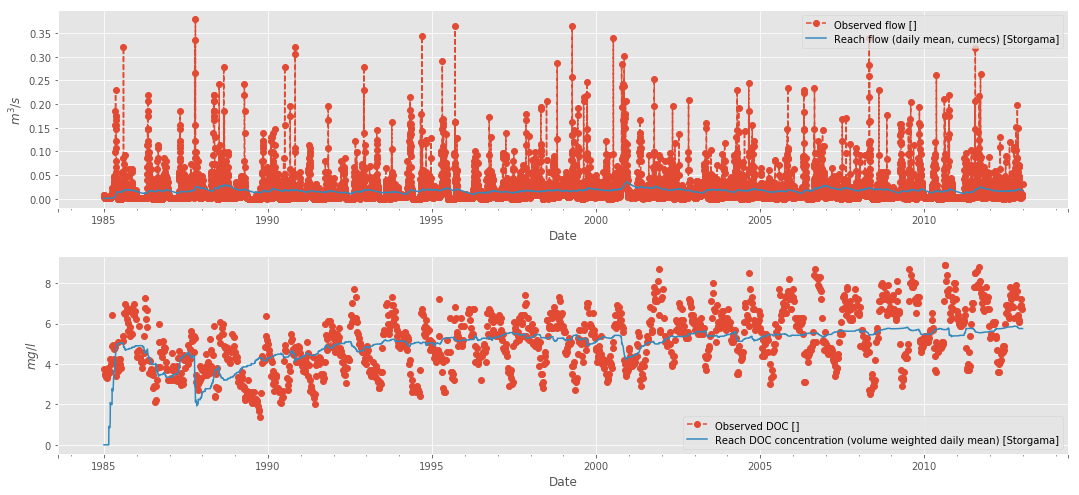

In [21]:
# Plot results from optimisation
cu.set_parameter_values(res.params, dataset)
dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)
dataset.write_parameters_to_file('optimal_parameters.dat')